# Assignment - 27 - MACHINE LEARNING - 7
## By Prakash Ghosh
---

### Problem Statement: 
### Predict how many points NBA players scored in the 2013-2014 season using the K-nearest neighbors algorithm
---

#### A look at the data

* Before we dive into the algorithm, let’s take a look at our data. Each row in the data contains information on how a player performed in the 2013-2014 NBA season.

* Download 'nba_2013.csv' file from this link: https://www.dropbox.com/s/b3nv38jjo5dxcl6/nba_2013.csv?dl=0

Here are some selected columns from the data:<br>
player - name of the player<br>
pos - the position of the player<br>
g - number of games the player was in<br>
gs - number of games the player started<br>
pts - total points the player scored<br>

There are many more columns in the data, mostly containing information about average player game performance over the course of the season. See this site for an explanation of the rest of them.

We can read our dataset in and figure out which columns are present:

import pandas<br>
with open("nba_2013.csv", 'r') as csvfile:<br>
nba = pandas.read_csv(csvfile)<br>

---

In [76]:
# Import Libraries
import numpy as np
import pandas as pd

import xgboost as xgb
import seaborn as sns
sns.set(font_scale = 1.5)
import matplotlib.pyplot as plt

from sklearn import metrics, model_selection, preprocessing, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

#### Load Data

In [77]:
# Read the dataset
csvfile="nba_2013.csv"
nba = pd.read_csv(csvfile)

In [79]:
nba.head(5)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


In [80]:
# Rename the column name - remove . from the name
col_name=['player', 'pos', 'age', 'bref_team_id', 'g', 'gs', 'mp', 'fg', 'fga',
       'fg_2', 'x3p', 'x3pa', 'x3p_2', 'x2p', 'x2pa', 'x2p_2', 'efg_2', 'ft',
       'fta', 'ft_2', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'season', 'season_end']
nba.columns=col_name

#### Analyze Data

In [81]:
nba.describe()

,age,g,gs,mp,fg,fga,fg_2,x3p,x3pa,x3p_2,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,season_end
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,479.000000,481.000000,481.000000,414.000000,...,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.0
mean,26.509356,53.253638,25.571726,1237.386694,192.881497,424.463617,0.436436,39.613306,110.130977,0.285111,...,55.810811,162.817048,218.627859,112.536383,39.280665,24.103950,71.862786,105.869023,516.582121,2013.0
std,4.198265,25.322711,29.658465,897.258840,171.832793,368.850833,0.098672,50.855639,132.751732,0.157633,...,62.101191,145.348116,200.356507,131.019557,34.783590,30.875381,62.701690,71.213627,470.422228,0.0
min,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.0
25%,23.000000,32.000000,0.000000,388.000000,47.000000,110.000000,0.400500,0.000000,3.000000,0.234355,...,12.000000,43.000000,55.000000,20.000000,9.000000,4.000000,21.000000,44.000000,115.000000,2013.0
50%,26.000000,61.000000,10.000000,1141.000000,146.000000,332.000000,0.438000,16.000000,48.000000,0.330976,...,35.000000,135.000000,168.000000,65.000000,32.000000,14.000000,58.000000,104.000000,401.000000,2013.0
75%,29.000000,76.000000,54.000000,2016.000000,307.000000,672.000000,0.479500,68.000000,193.000000,0.375000,...,73.000000,230.000000,310.000000,152.000000,60.000000,32.000000,108.000000,158.000000,821.000000,2013.0
max,39.000000,83.000000,82.000000,3122.000000,849.000000,1688.000000,1.000000,261.000000,615.000000,1.000000,...,440.000000,783.000000,1114.000000,721.000000,191.000000,219.000000,295.000000,273.000000,2593.000000,2013.0


In [82]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 31 columns):
player          481 non-null object
pos             481 non-null object
age             481 non-null int64
bref_team_id    481 non-null object
g               481 non-null int64
gs              481 non-null int64
mp              481 non-null int64
fg              481 non-null int64
fga             481 non-null int64
fg_2            479 non-null float64
x3p             481 non-null int64
x3pa            481 non-null int64
x3p_2           414 non-null float64
x2p             481 non-null int64
x2pa            481 non-null int64
x2p_2           478 non-null float64
efg_2           479 non-null float64
ft              481 non-null int64
fta             481 non-null int64
ft_2            461 non-null float64
orb             481 non-null int64
drb             481 non-null int64
trb             481 non-null int64
ast             481 non-null int64
stl             481 non-null int64
blk    

#### Prepare Data

In [83]:
# Fill null values with mean
nba.fg_2.fillna(nba.fg_2.mean(), inplace=True)
nba.x3p_2.fillna(nba.x3p_2.mean(), inplace=True)
nba.x2p_2.fillna(nba.x2p_2.mean(), inplace=True)
nba.efg_2.fillna(nba.efg_2.mean(), inplace=True)
nba.ft_2.fillna(nba.ft_2.mean(), inplace=True)

In [84]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 31 columns):
player          481 non-null object
pos             481 non-null object
age             481 non-null int64
bref_team_id    481 non-null object
g               481 non-null int64
gs              481 non-null int64
mp              481 non-null int64
fg              481 non-null int64
fga             481 non-null int64
fg_2            481 non-null float64
x3p             481 non-null int64
x3pa            481 non-null int64
x3p_2           481 non-null float64
x2p             481 non-null int64
x2pa            481 non-null int64
x2p_2           481 non-null float64
efg_2           481 non-null float64
ft              481 non-null int64
fta             481 non-null int64
ft_2            481 non-null float64
orb             481 non-null int64
drb             481 non-null int64
trb             481 non-null int64
ast             481 non-null int64
stl             481 non-null int64
blk    

In [85]:
# Convert Categorical Variable to Numerical Variable for Train Dataset
for feature in nba.columns: 
    if nba[feature].dtype == 'object': 
        nba[feature] = pd.Categorical(nba[feature]).codes 

nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 31 columns):
player          481 non-null int16
pos             481 non-null int8
age             481 non-null int64
bref_team_id    481 non-null int8
g               481 non-null int64
gs              481 non-null int64
mp              481 non-null int64
fg              481 non-null int64
fga             481 non-null int64
fg_2            481 non-null float64
x3p             481 non-null int64
x3pa            481 non-null int64
x3p_2           481 non-null float64
x2p             481 non-null int64
x2pa            481 non-null int64
x2p_2           481 non-null float64
efg_2           481 non-null float64
ft              481 non-null int64
fta             481 non-null int64
ft_2            481 non-null float64
orb             481 non-null int64
drb             481 non-null int64
trb             481 non-null int64
ast             481 non-null int64
stl             481 non-null int64
blk         

In [86]:
# Drop unwanted features 
nba.drop(['season','season_end','player','pos','bref_team_id'], axis=1, inplace=True)

In [87]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 26 columns):
age      481 non-null int64
g        481 non-null int64
gs       481 non-null int64
mp       481 non-null int64
fg       481 non-null int64
fga      481 non-null int64
fg_2     481 non-null float64
x3p      481 non-null int64
x3pa     481 non-null int64
x3p_2    481 non-null float64
x2p      481 non-null int64
x2pa     481 non-null int64
x2p_2    481 non-null float64
efg_2    481 non-null float64
ft       481 non-null int64
fta      481 non-null int64
ft_2     481 non-null float64
orb      481 non-null int64
drb      481 non-null int64
trb      481 non-null int64
ast      481 non-null int64
stl      481 non-null int64
blk      481 non-null int64
tov      481 non-null int64
pf       481 non-null int64
pts      481 non-null int64
dtypes: float64(5), int64(21)
memory usage: 97.8 KB


In [88]:
# Target and Feature selection
nba_y=nba.pop('pts')
nba_x=nba

In [89]:
nba_x.head(2)

,age,g,gs,mp,fg,fga,fg_2,x3p,x3pa,x3p_2,...,fta,ft_2,orb,drb,trb,ast,stl,blk,tov,pf
0,23,63,0,847,66,141,0.468,4,15,0.266667,...,53,0.660,72,144,216,28,23,26,30,122
1,20,81,20,1197,93,185,0.503,0,0,0.285111,...,136,0.581,142,190,332,43,40,57,71,203


In [90]:
# Split into train/test dataset (70%:30%)
x_train, x_test, y_train, y_test = model_selection.train_test_split(nba_x, nba_y, test_size = 0.3, random_state = 1)

In [91]:
x_train.head(5)

,age,g,gs,mp,fg,fga,fg_2,x3p,x3pa,x3p_2,...,fta,ft_2,orb,drb,trb,ast,stl,blk,tov,pf
344,31,68,68,1997,456,914,0.499,25,67,0.373134,...,243,0.811,17,138,155,388,36,9,151,86
218,21,71,71,2496,532,1237,0.430,123,344,0.357558,...,338,0.861,52,207,259,433,108,23,190,163
343,34,29,0,242,52,118,0.441,24,60,0.400000,...,11,0.727,1,19,20,52,14,1,26,17
162,23,80,80,2898,577,1362,0.424,182,500,0.364000,...,464,0.864,64,478,542,283,151,22,224,198
98,33,81,0,1353,134,241,0.556,4,17,0.235294,...,93,0.710,116,177,293,104,30,28,71,187


In [92]:
y_train.head(5)

344    1134
218    1478
343     136
162    1737
98      338
Name: pts, dtype: int64

In [93]:
x_test.head(5)

,age,g,gs,mp,fg,fga,fg_2,x3p,x3pa,x3p_2,...,fta,ft_2,orb,drb,trb,ast,stl,blk,tov,pf
293,22,45,10,897,113,300,0.377,22,59,0.372881,...,43,0.744,18,61,79,120,22,9,39,69
283,22,54,45,1564,170,419,0.406,71,178,0.398876,...,36,0.528,15,140,155,477,48,4,150,76
34,23,41,0,387,65,156,0.417,10,33,0.303030,...,32,0.813,16,58,74,33,9,7,18,31
399,25,70,1,1006,119,281,0.423,1,23,0.043478,...,39,0.564,31,98,129,179,49,13,65,66
432,28,64,9,1298,129,307,0.420,102,247,0.412955,...,41,0.805,33,135,168,42,19,15,23,82


In [94]:
y_test.head(5)

293    280
283    430
34     166
399    261
432    393
Name: pts, dtype: int64

In [95]:
curr_col_name=nba.columns
curr_col_name

Index(['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_2', 'x3p', 'x3pa', 'x3p_2',
       'x2p', 'x2pa', 'x2p_2', 'efg_2', 'ft', 'fta', 'ft_2', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf'],
      dtype='object')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

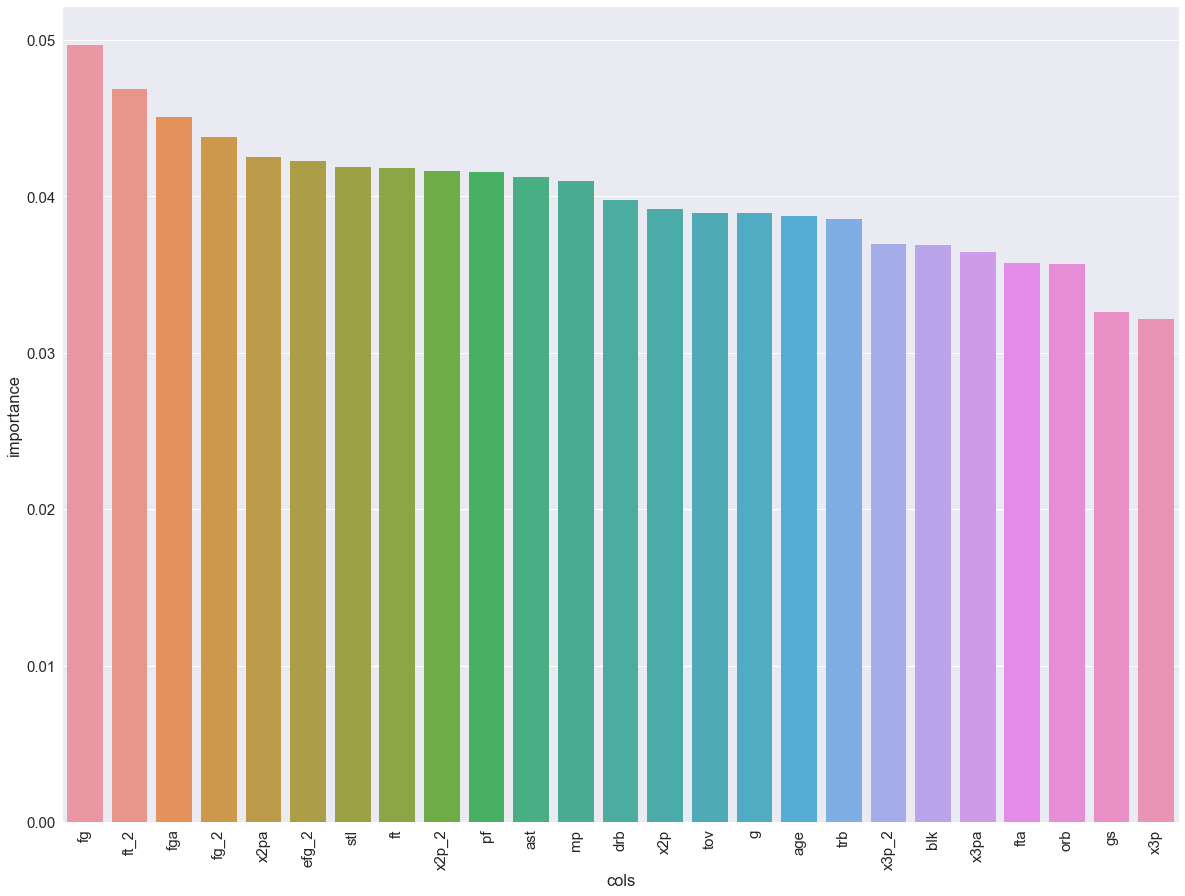

In [96]:
# Imp feature selection using Random Forest Classifier
rnd_forest_classifier = RandomForestClassifier(n_estimators=100)
rnd_forest_classifier.fit(x_train[curr_col_name], y_train)

rfc_importance = pd.DataFrame.from_dict({'cols':curr_col_name, 'importance': rnd_forest_classifier.feature_importances_})
rfc_importance = rfc_importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(20,15))
sns.barplot(rfc_importance.cols, rfc_importance.importance)
plt.xticks(rotation=90)

In [97]:
important_features = importance[importance.importance >= 0.04].cols.values
print(important_features)

['fg' 'ft_2' 'fga' 'x2p' 'x2p_2' 'mp' 'stl' 'fg_2' 'efg_2']


#### K-nearest neighbors algorithm

In [99]:
# Accuracy for K Values 
for K in range(6):
    K_value = K+1
    KNeighbors = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
    KNeighbors.fit(x_train[important_features], y_train) 
    y_pred = KNeighbors.predict(x_test[important_features])
    print("K-Value: ", K_value, " :  Accuracy: ",(y_pred.sum()/y_test.sum())*100,"%") 

K-Value:  1  :  Accuracy:  98.92334541549201 %
K-Value:  2  :  Accuracy:  92.8983756208887 %
K-Value:  3  :  Accuracy:  89.72882266075983 %
K-Value:  4  :  Accuracy:  87.6896227681568 %
K-Value:  5  :  Accuracy:  85.51080681970734 %
K-Value:  6  :  Accuracy:  84.31735803463553 %


In [100]:
KNeighbors = KNeighborsClassifier(n_neighbors = 2, weights='uniform', algorithm='auto')
KNeighbors.fit(x_train[important_features], y_train)
y_pred=KNeighbors.predict(x_test[important_features])
print("K-Value:  2  :  Accuracy: ", (y_pred.sum()/y_test.sum())*100,"%")

K-Value:  2  :  Accuracy:  92.8983756208887 %


In [101]:
x_test['Actual_PT']= y_test
x_test['Predicted_PT']= y_pred

C:\Users\praka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\praka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [102]:
# Actual and Predcited values
X_test.head(10)

,age,g,gs,mp,fg,fga,fg_2,x3p,x3pa,x3p_2,...,trb,ast,stl,blk,tov,pf,Actual_pts,Predicted_pts,Actual_pts2,Predicted_pts2
293,22,45,10,897,113,300,0.377,22,59,0.372881,...,79,120,22,9,39,69,280,273,280,273
283,22,54,45,1564,170,419,0.406,71,178,0.398876,...,155,477,48,4,150,76,430,378,430,378
34,23,41,0,387,65,156,0.417,10,33,0.303030,...,74,33,9,7,18,31,166,110,166,110
399,25,70,1,1006,119,281,0.423,1,23,0.043478,...,129,179,49,13,65,66,261,248,261,248
432,28,64,9,1298,129,307,0.420,102,247,0.412955,...,168,42,19,15,23,82,393,298,393,298
364,30,14,0,95,7,14,0.500,0,0,0.285111,...,25,1,3,1,5,15,20,14,20,14
349,29,62,62,1207,87,193,0.451,0,1,0.000000,...,305,67,26,32,90,177,211,265,211,265
66,23,26,0,224,26,86,0.302,3,30,0.100000,...,28,41,13,3,16,19,64,54,64,54
250,22,59,25,1312,157,371,0.423,48,142,0.338028,...,219,95,32,45,47,147,472,404,472,404
31,28,42,39,1257,222,502,0.442,30,108,0.277778,...,222,45,14,52,58,100,558,401,558,401
